In [5]:
import pandas as pd
import numpy as np

orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
payments = pd.read_csv("data/olist_order_payments_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")


In [6]:
orders = orders[orders["order_status"] == "delivered"].copy()

In [7]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

In [8]:
# target variable
orders["is_late"] = (
    orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"]
).astype(int)

In [9]:
order_items_agg = (
    order_items.groupby("order_id")
    .agg(
        n_items=("order_item_id", "count"),
        total_price=("price", "sum"),
        total_freight=("freight_value", "sum"),
        avg_price=("price", "mean"),
    )
    .reset_index()
)

In [10]:
payments_agg = (
    payments.groupby("order_id")
    .agg(
        payment_value=("payment_value", "sum"),
        payment_installments=("payment_installments", "max"),
        main_payment_type=("payment_type", lambda x: x.mode()[0] if len(x) > 0 else np.nan),
    )
    .reset_index()
)

In [11]:
orders = orders.merge(
    customers[["customer_id", "customer_unique_id", "customer_state"]],
    on="customer_id", how="left"
)

seller_info = (
    order_items[["order_id", "seller_id"]]
    .merge(sellers[["seller_id", "seller_state"]], on="seller_id", how="left")
    .groupby("order_id")
    .agg(seller_state=("seller_state", "first"))
    .reset_index()
)
orders = orders.merge(seller_info, on="order_id", how="left")

In [12]:
df = (
    orders
    .merge(order_items[["order_id", "seller_id"]].drop_duplicates(), on="order_id", how="left")
    .merge(order_items_agg, on="order_id", how="left")
    .merge(payments_agg, on="order_id", how="left")
)

df["purchase_to_estimated_days"] = (
    df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]
).dt.days
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_dow"] = df["order_purchase_timestamp"].dt.dayofweek

df["same_state"] = (df["customer_state"] == df["seller_state"]).astype(int)

In [13]:
reviews["review_creation_date"] = pd.to_datetime(
    reviews["review_creation_date"], errors="coerce"
)

seller_reviews = (
    order_items
    .merge(reviews[["order_id", "review_score", "review_creation_date"]], on="order_id", how="left")
    .merge(orders[["order_id", "order_purchase_timestamp"]], on="order_id", how="left")
    .dropna(subset=["review_score", "review_creation_date", "order_purchase_timestamp"])
)

def past_avg_by_time(group):
    group = group.sort_values("review_creation_date").reset_index(drop=True)
    past_means = []
    for i, row in group.iterrows():
        mask = group["review_creation_date"] < row["order_purchase_timestamp"]
        past_scores = group.loc[mask, "review_score"]
        past_means.append(past_scores.mean() if len(past_scores) > 0 else np.nan)
    group["seller_avg_score_past"] = past_means
    return group

seller_reviews = seller_reviews.groupby("seller_id", group_keys=False).apply(past_avg_by_time)

order_seller_avg = (
    seller_reviews.groupby("order_id")["seller_avg_score_past"]
    .mean()
    .reset_index()
)

df = df.merge(order_seller_avg, on="order_id", how="left")

/var/folders/ff/5t6ph_yd6j1clj5h31xk43fc0000gn/T/ipykernel_93392/1575350239.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seller_reviews = seller_reviews.groupby("seller_id", group_keys=False).apply(past_avg_by_time)


In [ ]:
print("Final dataset shape:", df.shape)
print(df.head())
df.reset_index(drop=True, inplace=True)


Final dataset shape: (97819, 25)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26

/var/folders/ff/5t6ph_yd6j1clj5h31xk43fc0000gn/T/ipykernel_93392/1849376037.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="is_late", data=df, palette="Reds")


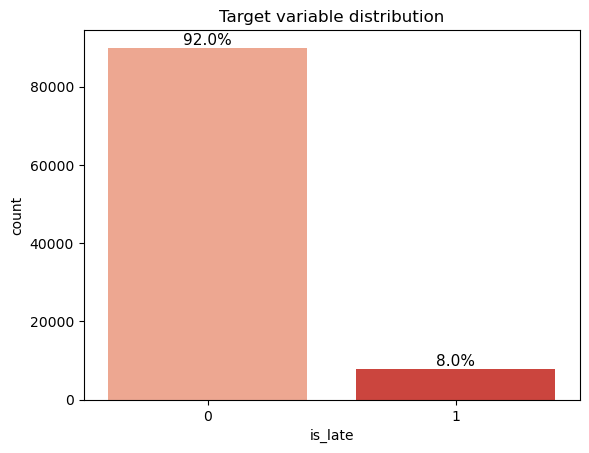

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.countplot(x="is_late", data=df, palette="Reds")
plt.title("Target variable distribution")
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=11)

plt.show()

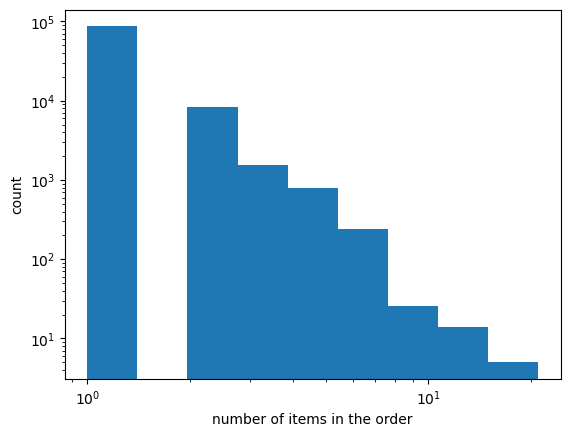

In [12]:
df["n_items"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["n_items"])),10)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('number of items in the order')
plt.ylabel('count')
plt.show()

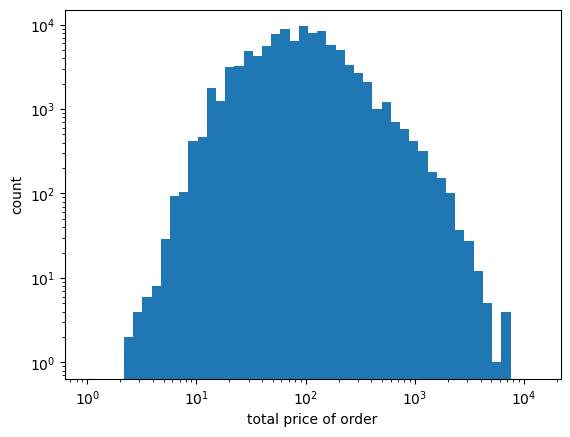

In [34]:
df["total_price"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["total_price"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('total price of order')
plt.ylabel('count')
plt.show()

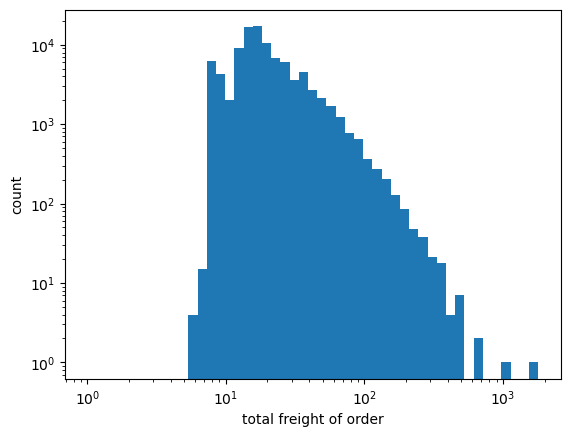

In [17]:
df["total_freight"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["total_freight"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('total freight of order')
plt.ylabel('count')
plt.show()

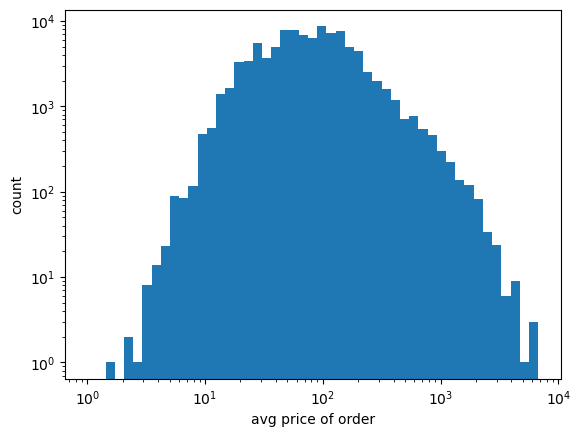

In [18]:
df["avg_price"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["avg_price"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('avg price of order')
plt.ylabel('count')
plt.show()

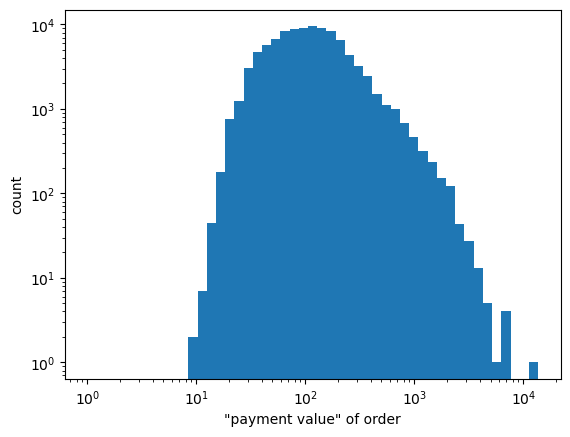

In [19]:
df["payment_value"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["payment_value"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('"payment value" of order')
plt.ylabel('count')
plt.show()

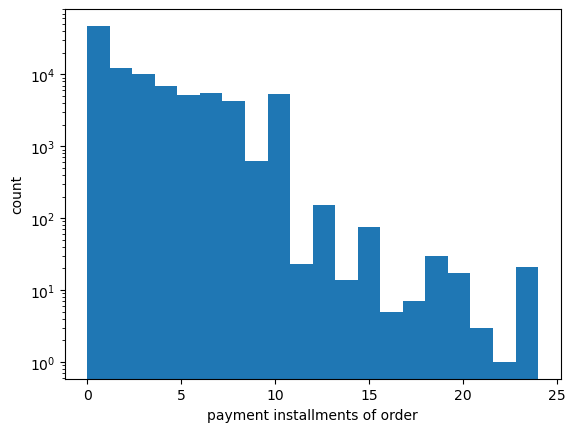

In [20]:
df["payment_installments"].plot.hist(bins =20) 
plt.semilogy()
plt.xlabel('payment installments of order')
plt.ylabel('count')
plt.show()

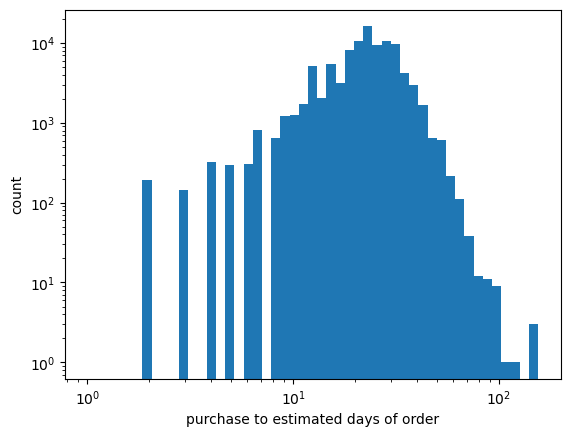

In [22]:
df["purchase_to_estimated_days"].plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df["purchase_to_estimated_days"])),50)) 
plt.semilogy()
plt.semilogx()
plt.xlabel('purchase to estimated days of order')
plt.ylabel('count')
plt.show()

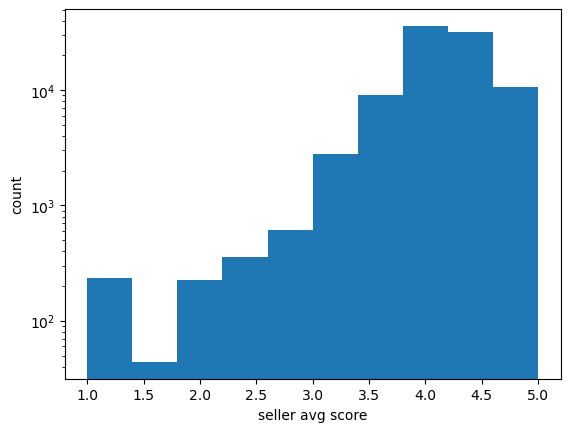

In [28]:
df["seller_avg_score_past"].plot.hist(bins=10)
plt.semilogy()
# plt.semilogx()
plt.xlabel('seller avg score')
plt.ylabel('count')
plt.show()

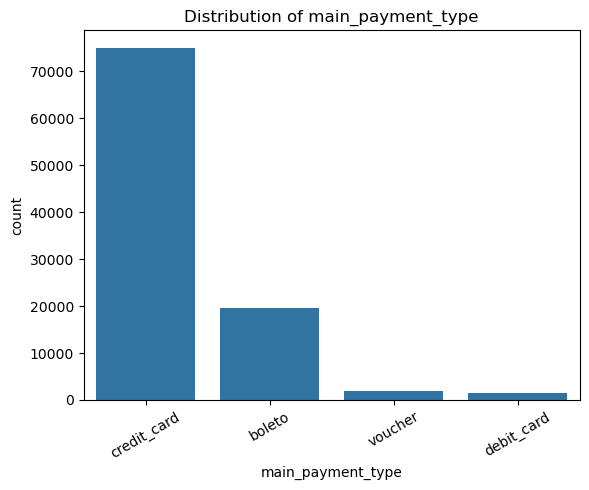

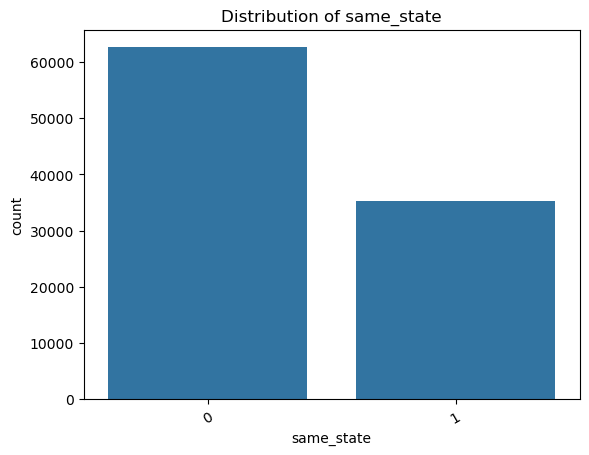

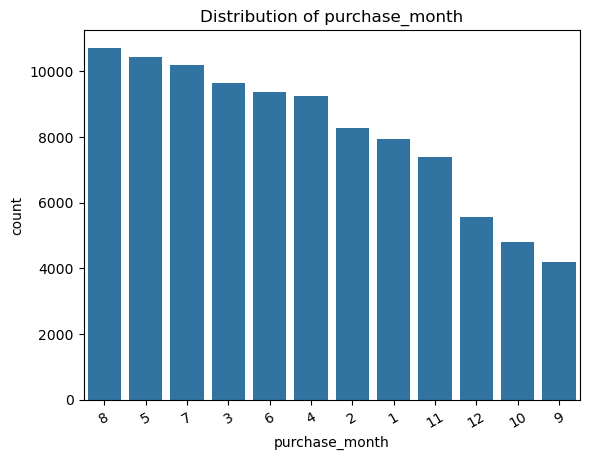

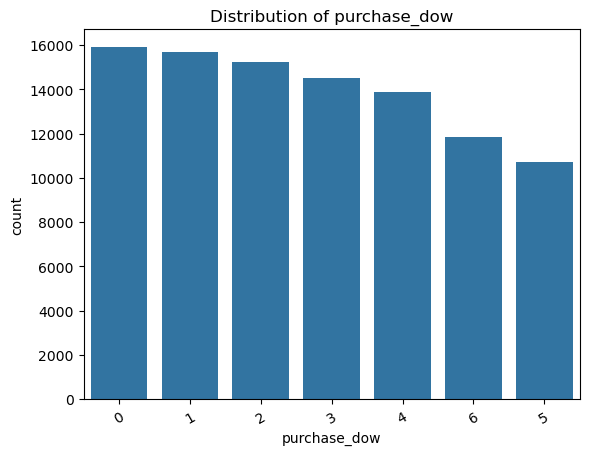

In [13]:
categorical_colsforpic = ["main_payment_type", "same_state", "purchase_month", "purchase_dow"]

for col in categorical_colsforpic:
    plt.figure()
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=30)
    plt.show()

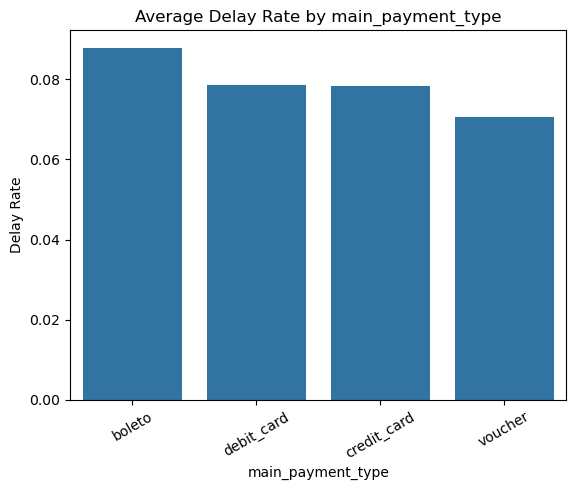

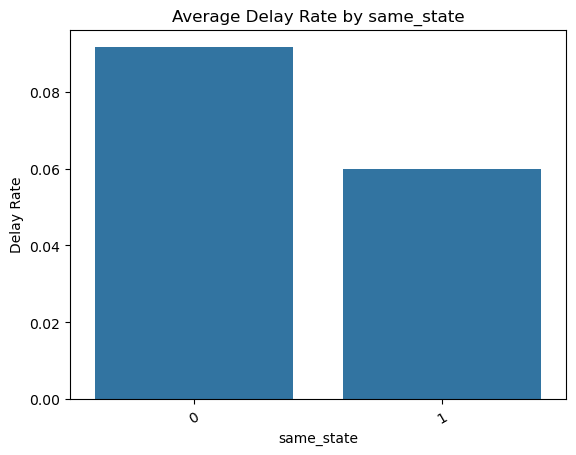

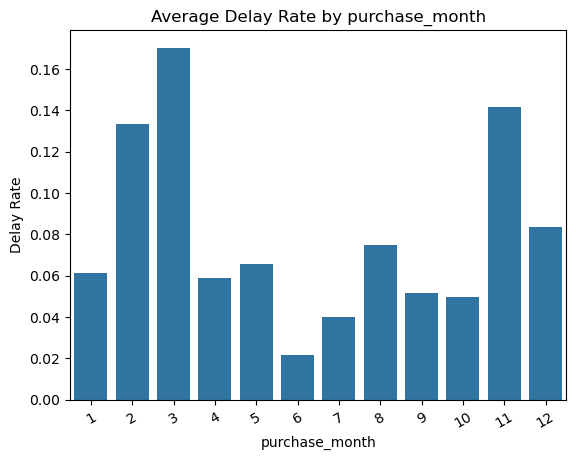

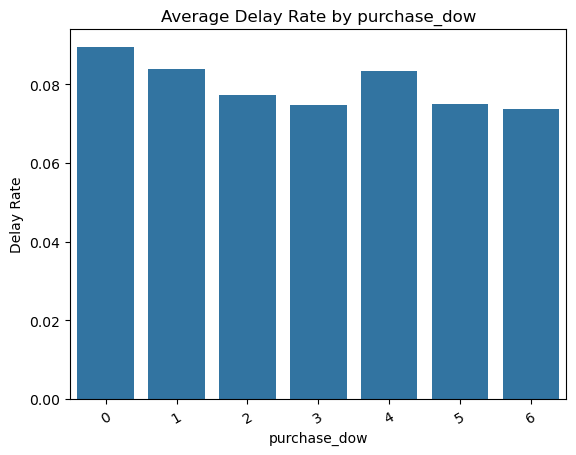

In [14]:
for col in categorical_colsforpic:
    late_by_cat = df.groupby(col)["is_late"].mean().sort_values(ascending=False)
    plt.figure()
    sns.barplot(x=late_by_cat.index, y=late_by_cat.values)
    plt.title(f"Average Delay Rate by {col}")
    plt.ylabel("Delay Rate")
    plt.xticks(rotation=30)
    plt.show()

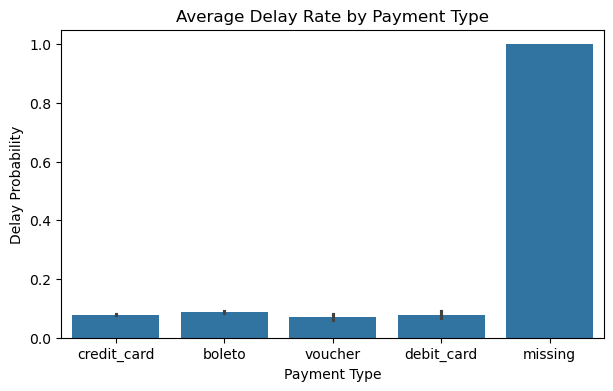

/var/folders/ff/5t6ph_yd6j1clj5h31xk43fc0000gn/T/ipykernel_93392/999263250.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


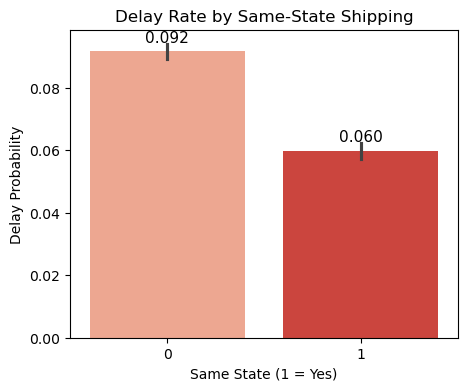

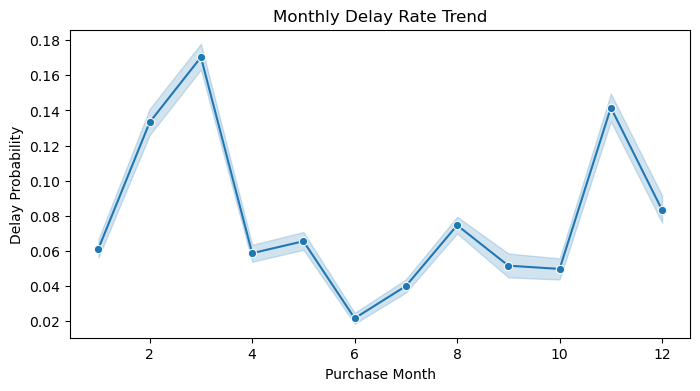

In [ ]:
plt.figure(figsize=(7,4))
sns.barplot(x="main_payment_type", y="is_late", data=df, estimator=np.mean, order=df["main_payment_type"].value_counts().index)
plt.title("Average Delay Rate by Payment Type")
plt.ylabel("Delay Probability")
plt.xlabel("Payment Type")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(x="purchase_month", y="is_late", data=df, estimator=np.mean, marker="o")
plt.title("Monthly Delay Rate Trend")
plt.ylabel("Delay Probability")
plt.xlabel("Purchase Month")
plt.show()

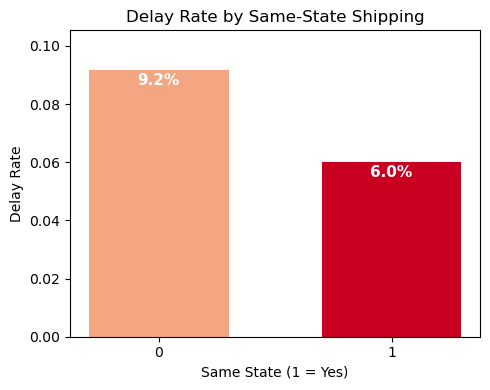

In [42]:
import matplotlib.pyplot as plt
import numpy as np
mean_values = df.groupby("same_state")["is_late"].mean()

x = mean_values.index
y = mean_values.values

plt.figure(figsize=(5,4))
bars = plt.bar(
    x, 
    y, 
    color=["#f4a582", "#ca0020"],
    align='center', 
    width=0.6
)

plt.title("Delay Rate by Same-State Shipping")
plt.ylabel("Delay Rate")
plt.xlabel("Same State (1 = Yes)")
plt.xticks([0, 1], ["0", "1"])  

for i, v in enumerate(y):
    plt.text(
        x[i], 
        v - 0.006,               
        f"{v*100:.1f}%", 
        ha="center", 
        va="bottom",
        fontsize=11, 
        color="white",            
        fontweight="bold"
    )

plt.ylim(0, max(y) * 1.15)
plt.tight_layout()
plt.show()

In [16]:
delay_by_state = (
    df.groupby("customer_state")["is_late"]
    .mean()
    .reset_index(name="delay_rate")
)

In [17]:
! pip install geopandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Index(['id', 'name', 'sigla', 'regiao_id', 'codigo_ibg', 'cartodb_id',
       'created_at', 'updated_at', 'geometry'],
      dtype='object')


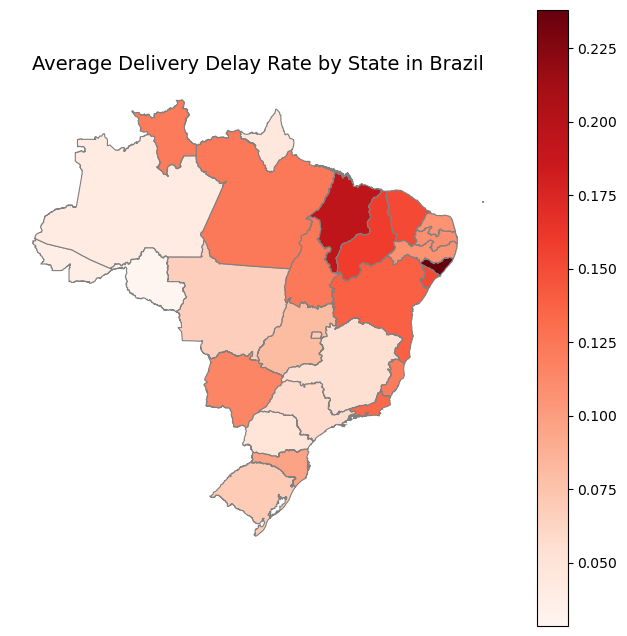

In [18]:
import geopandas as gpd

brazil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

print(brazil.columns)
brazil["state"] = brazil["sigla"] if "sigla" in brazil.columns else brazil["abbrev"]
brazil = brazil.merge(delay_by_state, left_on="state", right_on="customer_state", how="left")
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
brazil.plot(column="delay_rate",
            cmap="Reds",
            linewidth=0.8,
            edgecolor="gray",
            legend=True,
            ax=ax)

ax.set_title("Average Delivery Delay Rate by State in Brazil", fontsize=14)
ax.axis("off")
plt.show()

In [31]:
def missing_value_summary(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0] 
    if missing.empty:
        print("No missing values in this dataset.")
        return None
    missing_df = pd.DataFrame({
        "Missing Count": missing,
        "Missing %": (missing / len(df) * 100).round(9)
    }).sort_values(by="Missing %", ascending=False)
    return missing_df

print("\nMissing Value Summary (Train+Val set):")
display(missing_value_summary(df))



Missing Value Summary (Train+Val set):


,Missing Count,Missing %
seller_avg_score_past,5939,6.071418
payment_value,1,0.001022
payment_installments,1,0.001022


In [32]:
numerical_features = [
    "n_items", "total_price", "total_freight", "avg_price",
    "payment_value", "seller_avg_score_past",
    "purchase_to_estimated_days"
]
ordinal_linear = ["payment_installments"]
ordinal_cyclic = ["purchase_month", "purchase_dow"]

categorical_features = ["main_payment_type", "same_state", "customer_state", "seller_state"]

for col in categorical_features:
    df[col] = df[col].fillna("missing")


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
drop_cols = [
    "order_id", "customer_id", "seller_id",
    "order_status",
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

numerical_features = [
    "n_items", "total_price", "total_freight", "avg_price",
    "payment_value", "seller_avg_score_past",
    "purchase_to_estimated_days"
]
ordinal_linear = ["payment_installments"]
ordinal_cyclic = ["purchase_month", "purchase_dow"]
categorical_features = ["main_payment_type", "same_state", "customer_state", "seller_state"]

X = df.drop(columns=["is_late"])
y = df["is_late"]
groups = df["customer_unique_id"]

X_other, X_test, y_other, y_test = train_test_split(
    X, y, test_size=0.2, random_state=521, stratify=y
)

print(f"Train+Val size: {X_other.shape}, Test size: {X_test.shape}")

def encode_cyclic_features(df):
    df = df.copy()
    return pd.DataFrame({
        "month_sin": np.sin(2 * np.pi * df["purchase_month"] / 12),
        "month_cos": np.cos(2 * np.pi * df["purchase_month"] / 12),
        "dow_sin": np.sin(2 * np.pi * df["purchase_dow"] / 7),
        "dow_cos": np.cos(2 * np.pi * df["purchase_dow"] / 7),
    })

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features + ordinal_linear),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("cyclic", FunctionTransformer(encode_cyclic_features), ordinal_cyclic)
    ]
)

kf = KFold(n_splits=5, shuffle=True, random_state=521)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_other), 1):
    print(f"\nFold {fold}")
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]
    
    preprocessor.fit(X_train)
    X_train_pre = preprocessor.transform(X_train)
    X_val_pre = preprocessor.transform(X_val)
    X_test_pre = preprocessor.transform(X_test)
    
    print(f"Train shape: {X_train_pre.shape}, Val shape: {X_val_pre.shape}, Test shape: {X_test_pre.shape}")

Train+Val size: (78255, 15), Test size: (19564, 15)

Fold 1
Train shape: (62604, 68), Val shape: (15651, 68), Test shape: (19564, 68)

Fold 2
Train shape: (62604, 67), Val shape: (15651, 67), Test shape: (19564, 67)

Fold 3
Train shape: (62604, 67), Val shape: (15651, 67), Test shape: (19564, 67)

Fold 4
Train shape: (62604, 68), Val shape: (15651, 68), Test shape: (19564, 68)

Fold 5
Train shape: (62604, 68), Val shape: (15651, 68), Test shape: (19564, 68)
